In [1]:
import sys
sys.path.append("../")

import torch
from torch.utils.data import DataLoader
import numpy as np
from model import MSBERT
from sklearn.manifold import TSNE

from utils import ModelEmbed
from const import tsne_cluster
from type import TokenizerConfig
from data import Tokenizer, TokenSequenceDataset

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model_state_path = "/data1/xp/data/MSBert/MSBERT.pkl"
model_state = torch.load(model_state_path)

model = MSBERT(
    100002,
    512,
    6,
    16,
    0,
    100,
    3
)
model.load_state_dict(model_state)
model = model.to(device)

show_progress_bar = False
tokenizer_config = TokenizerConfig(
    max_len=100,
    n_decimals=2,
    show_progress_bar=show_progress_bar
)
tokenizer = Tokenizer(**tokenizer_config)

In [3]:
from collections import defaultdict

def get_smiles_compound_name(spectra):
    smiles2spectra = defaultdict(list)
    for s in spectra:
        smiles = s.get("smiles")
        smiles2spectra[smiles].append(s)
    smiles2spectra = dict(smiles2spectra)

    smiles_seq = []
    lengths = []
    compund_names = []

    for k, v in smiles2spectra.items():
        smiles_seq.append(k)
        lengths.append(len(v))
        compund_names.append(v[0].get("compound_name"))
    
    smiles_seq = np.array(smiles_seq)
    lengths = np.array(lengths)
    compund_names = np.array(compund_names)
    indices = np.argsort(lengths)[::-1][:10]
    tsne_spectra = []
    labels = []
    for smiles, length, compound_name in zip(smiles_seq[indices], lengths[indices], compund_names[indices]):
        tsne_spectra.extend(smiles2spectra[smiles])
        if len(compound_name) > 30:
            compound_name = "Veratric acid"
        labels.extend([compound_name] * length)
    return np.array(tsne_spectra), np.array(labels)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

sns.set_style("whitegrid")
sns.set_palette("tab10")

fm.fontManager.addfont('/usr/share/fonts/truetype/msttcorefonts/times.ttf')
plt.rcParams['font.family'] = 'Times New Roman'

def tsne_plot(data, labels):
    figure, ax = plt.subplots(1, 1, dpi=300, figsize=(4, 3))
    sns.scatterplot(
        x=data[:, 0], 
        y=data[:, 1], 
        hue=labels, 
        ax=ax, 
        edgecolor='none', 
        s=10,
        alpha=0.7
    )
    ax.legend().remove()
    # ax.legend(bbox_to_anchor=(1.02, 0.5), ncol=1, loc="center left", frameon=False)
    figure.tight_layout()
    return figure

In [5]:
spectra = np.load(tsne_cluster.SPECEMBEDDING_TSNE, allow_pickle=True)
spectra, labels = get_smiles_compound_name(spectra)

sequences = tokenizer.tokenize_sequence(spectra)
dataset = TokenSequenceDataset(sequences)
loader = DataLoader(
    dataset,
    batch_size=512,
    shuffle=False
)

spectra_embedding = ModelEmbed(model, loader, device)
tsne = TSNE()
data = tsne.fit_transform(spectra_embedding)

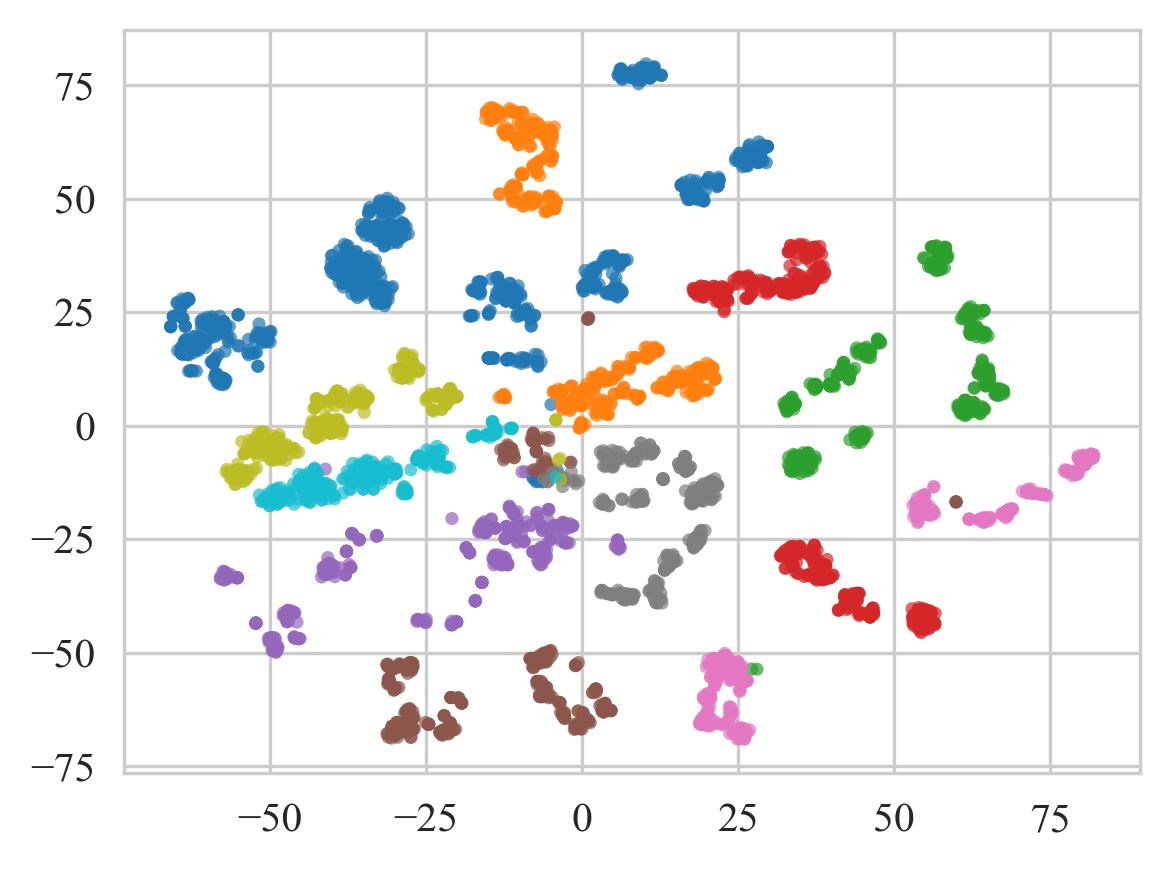

In [6]:
f_sm = tsne_plot(data, labels)
f_sm.savefig("./figures/tsne_sm.svg", transparent=True, bbox_inches="tight")
f_sm.savefig("./figures/tsne_sm.png", transparent=True, bbox_inches="tight")
f_sm.savefig("./figures/tsne_sm.pdf", transparent=True, bbox_inches="tight")

In [7]:
spectra = np.load(tsne_cluster.MSBERT_TSNE, allow_pickle=True)
spectra, labels = get_smiles_compound_name(spectra)

sequences = tokenizer.tokenize_sequence(spectra)
dataset = TokenSequenceDataset(sequences)
loader = DataLoader(
    dataset,
    batch_size=512,
    shuffle=False
)

spectra_embedding = ModelEmbed(model, loader, device)
tsne = TSNE()
data = tsne.fit_transform(spectra_embedding)

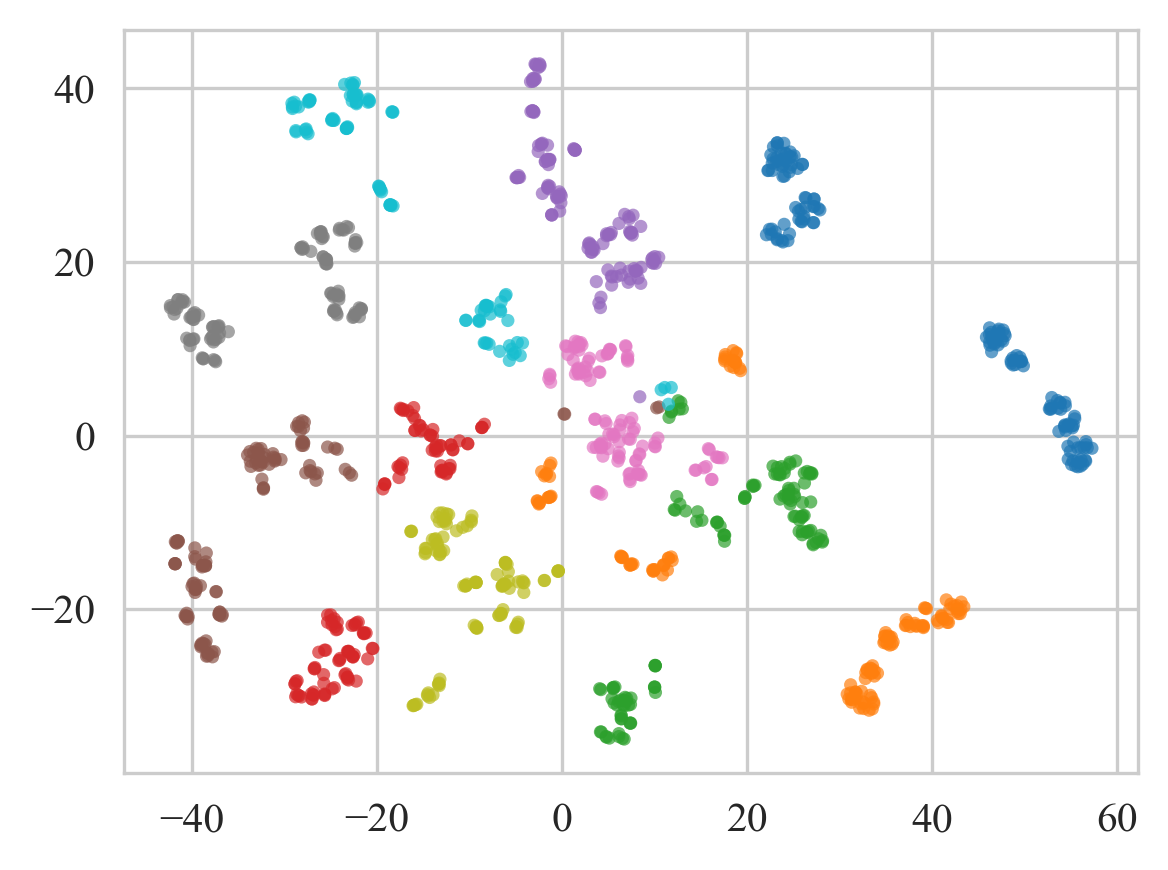

In [8]:
f_mb = tsne_plot(data, labels)
f_mb.savefig("./figures/tsne_mb.svg", transparent=True, bbox_inches="tight")
f_mb.savefig("./figures/tsne_mb.png", transparent=True, bbox_inches="tight")
f_mb.savefig("./figures/tsne_mb.pdf", transparent=True, bbox_inches="tight")